# Cartpole Problem

The state and control vectors $\textbf{x}$ and $\textbf{u}$ are defined as follows:

$$
\begin{equation*}
\textbf{x} = \begin{bmatrix}
    x & \dot{x} & \theta & \dot{\theta}
    \end{bmatrix}^T
\end{equation*}
$$

$$
\begin{equation*}
\textbf{u} = \begin{bmatrix}
    F_{x}
    \end{bmatrix}^T
\end{equation*}
$$

The goal is to swing the pendulum upright:

$$
\begin{equation*}
\textbf{x}_{goal} = \begin{bmatrix}
    0 & 0 & 0 & 0
    \end{bmatrix}^T
\end{equation*}
$$

**Note**: The force is constrained between $-1$ and $1$. This is achieved by
instead fitting for unconstrained actions and then applying it to a squashing
function $\tanh(\textbf{u})$. This is directly embedded into the dynamics model
in order to be auto-differentiated. This also means that we need to apply this
transformation manually to the output of our iLQR at the end.

In [1]:
%matplotlib inline

In [2]:
from __future__ import print_function

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
from ilqr import iLQR
from ilqr.cost import QRCost
from ilqr.dynamics import constrain
from ilqr.examples.cartpole import CartpoleDynamics

In [5]:
def on_iteration(iteration_count, xs, us, J_opt, accepted, converged):
    J_hist.append(J_opt)
    info = "converged" if converged else ("accepted" if accepted else "failed")
    final_state = dynamics.reduce_state(xs[-1])
    print("iteration", iteration_count, info, J_opt, final_state)

In [6]:
dt = 0.05
pole_length = 1.0
dynamics = CartpoleDynamics(dt, l=pole_length)

In [7]:
# Note that the augmented state is not all 0.
x_goal = dynamics.augment_state(np.array([0.0, 0.0, 0.0, 0.0]))

# Instantenous state cost.
Q = np.eye(dynamics.state_size)
Q[0, 0] = 1.0
Q[1, 1] = Q[4, 4] = 0.0
Q[0, 2] = Q[2, 0] = pole_length
Q[2, 2] = Q[3, 3] = pole_length**2
R = 0.1 * np.eye(dynamics.action_size)

# Terminal state cost.
Q_terminal = 100 * np.eye(dynamics.state_size)

# Instantaneous control cost.
R = np.array([[0.1]])

cost = QRCost(Q, R, Q_terminal=Q_terminal, x_goal=x_goal)

In [8]:
N = 500
x0 = dynamics.augment_state(np.array([0.0, 0.0, np.pi, 0.0]))
us_init = np.random.uniform(-1, 1, (N, dynamics.action_size))
ilqr = iLQR(dynamics, cost, N)

In [9]:
J_hist = []
xs, us = ilqr.fit(x0, us_init, n_iterations=500, on_iteration=on_iteration)

iteration 0 accepted 4173.579225283259 [ 0.44845873 -0.0685024  -1.84539052 -3.10015381]
iteration 1 accepted 2399.2392087871817 [ 0.34180895 -0.06143622 -1.04055404 -1.15359131]
iteration 2 accepted 1975.880184564144 [ 0.23738316 -0.06426659 -0.82800917 -0.5330121 ]
iteration 3 accepted 1876.8147054922651 [-0.26021733  0.0690383  -0.49042832  0.54467719]
iteration 4 accepted 1797.5753456805307 [-0.13228839  0.06928104 -0.49425038  0.41446018]
iteration 5 accepted 1764.5035888626326 [-0.02606962  0.09624203 -0.46856627  0.25337827]
iteration 6 accepted 1760.9101959435152 [-0.00697238  0.07967963 -0.46672577  0.22890572]
iteration 7 accepted 1751.4322342410478 [ 0.02139727  0.05578715 -0.46858083  0.18366658]
iteration 8 accepted 1745.310326645476 [ 0.02148543  0.05532099 -0.46351301  0.182454  ]
iteration 9 accepted 1734.3693958527858 [ 0.02024228  0.05724433 -0.43263677  0.18555229]
iteration 10 accepted 1732.9347417413203 [ 0.02384076  0.05434426 -0.41315089  0.17823485]
iteration 11

iteration 92 accepted 1528.324928889816 [-0.01865941  0.15516186 -0.12802089  0.22998035]
iteration 93 accepted 1527.9965337596848 [-0.0133058   0.16054835 -0.11972665  0.23703526]
iteration 94 accepted 1527.4870412499276 [ 0.00116468  0.17044075 -0.11522005  0.25279267]
iteration 95 accepted 1525.290563069345 [-0.00089442  0.16624842 -0.11848397  0.24699475]
iteration 96 accepted 1524.2501053089402 [-0.00713027  0.16303487 -0.11695105  0.24095374]
iteration 97 accepted 1524.0834183883003 [-0.00984633  0.1679895  -0.11269549  0.24531886]
iteration 98 accepted 1523.9174676082428 [ 0.00156928  0.1790787  -0.10802567  0.26209826]
iteration 99 accepted 1521.5453694974176 [-0.00182746  0.17542125 -0.11189034  0.25698489]
iteration 100 accepted 1520.569364147168 [-0.0089822   0.17251844 -0.10988508  0.25140512]
iteration 101 accepted 1520.4795259830953 [-0.01206362  0.17696747 -0.10691378  0.25538697]
iteration 102 accepted 1520.258661262446 [ 0.00035574  0.18837146 -0.10070136  0.27269211]


iteration 182 accepted 1474.5489372694374 [-0.03187437  0.26288852 -0.01743185  0.35067017]
iteration 183 accepted 1474.3625559170814 [-0.02976847  0.26749504 -0.01986291  0.3574847 ]
iteration 184 accepted 1473.8044288203673 [-0.02944612  0.26614331 -0.01695221  0.35578759]
iteration 185 accepted 1473.7583922024726 [-0.03288818  0.26820864 -0.01905135  0.35808394]
iteration 186 accepted 1473.1142060472846 [-0.03087983  0.2679262  -0.01586663  0.35818557]
iteration 187 accepted 1472.7709253733015 [-0.03263469  0.2695232  -0.01680343  0.36007654]
iteration 188 accepted 1472.7370007300126 [-0.03179864  0.27123755 -0.01204188  0.36264665]
iteration 189 accepted 1472.3090663106675 [-0.02868567  0.27528617 -0.01474998  0.36860631]
iteration 190 accepted 1471.6266201109327 [-0.02829679  0.27375675 -0.01200218  0.36660187]
iteration 191 accepted 1471.6066025746577 [-0.03224104  0.27546506 -0.01329469  0.36825269]
iteration 192 accepted 1470.894998129319 [-0.02955003  0.27493205 -0.01093098  0

In [30]:
# Reduce the state to something more reasonable.
xs = dynamics.reduce_state(xs)

# Constrain the actions to see what's actually applied to the system.
us = constrain(us, dynamics.min_bounds, dynamics.max_bounds)

In [31]:
t = np.arange(N + 1) * dt
x = xs[:, 0]
x_dot = xs[:, 1]
theta = np.unwrap(xs[:, 2])  # Makes for smoother plots.
theta_dot = xs[:, 3]

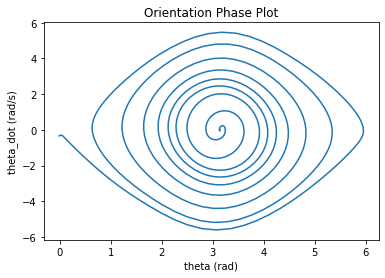

In [32]:
_ = plt.plot(theta, theta_dot)
_ = plt.xlabel("theta (rad)")
_ = plt.ylabel("theta_dot (rad/s)")
_ = plt.title("Orientation Phase Plot")

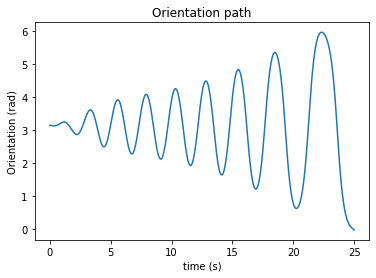

In [33]:
_ = plt.plot(t, theta)
_ = plt.xlabel("time (s)")
_ = plt.ylabel("Orientation (rad)")
_ = plt.title("Orientation path")

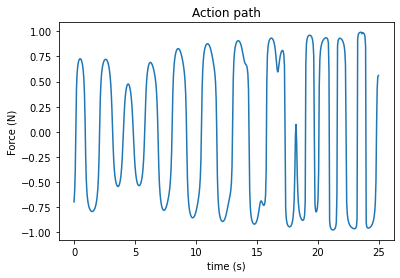

In [34]:
_ = plt.plot(t[:-1], us)
_ = plt.xlabel("time (s)")
_ = plt.ylabel("Force (N)")
_ = plt.title("Action path")

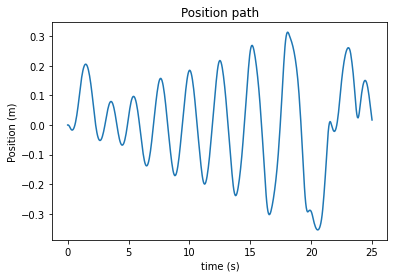

In [35]:
_ = plt.plot(t, x)
_ = plt.xlabel("time (s)")
_ = plt.ylabel("Position (m)")
_ = plt.title("Position path")

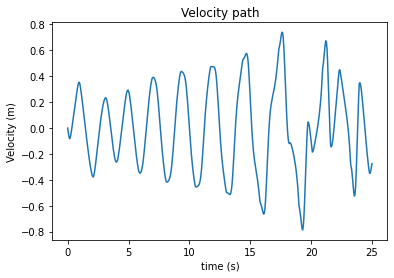

In [36]:
_ = plt.plot(t, x_dot)
_ = plt.xlabel("time (s)")
_ = plt.ylabel("Velocity (m)")
_ = plt.title("Velocity path")

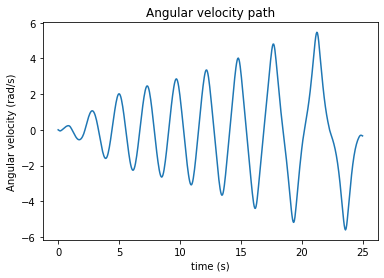

In [37]:
_ = plt.plot(t, theta_dot)
_ = plt.xlabel("time (s)")
_ = plt.ylabel("Angular velocity (rad/s)")
_ = plt.title("Angular velocity path")

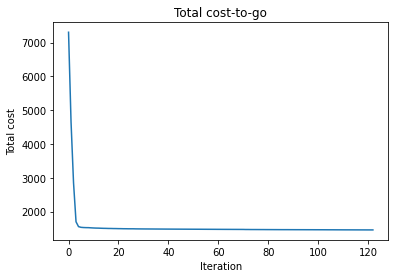

In [38]:
_ = plt.plot(J_hist)
_ = plt.xlabel("Iteration")
_ = plt.ylabel("Total cost")
_ = plt.title("Total cost-to-go")